<a href="https://colab.research.google.com/github/convergencelab/LSHT-HSLT-MODIS-Landsat-Fusion/blob/master/investigating_SR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SR-GAN: Super-Resolution Generative Adversarial Network

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [52]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, PReLU, Flatten, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow_datasets as tfds
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.2.0


In [7]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Architecture

In [8]:
# Define ResLayer
class ResLayer(tf.keras.layers.Layer):
  def __init__(self, kernel_size, filters, momentum, strides):
    super(ResLayer, self).__init__()
    filters1, filters2 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1), strides=strides)
    self.bn2a = tf.keras.layers.BatchNormalization(momentum=momentum)

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same', strides=strides)
    self.bn2b = tf.keras.layers.BatchNormalization(momentum=momentum)

  def call(self, input_tensor, training=False):
      x = self.conv2a(input_tensor)
      x = self.bn2a(x, training=training)
      x = tf.nn.relu(x)

      # skip activation on last one #
      x = self.conv2b(x)
      x = self.bn2b(x, training=training)

      x += input_tensor
      return tf.nn.relu(x)

Gan consists of a Discriminator and Generator:

In [9]:
# Define the discriminator.
class Discriminator(Model):
    def __init__(self,
                 momentum=0.8,
                 leakyrelu_alpha=0.2,
                 **kwargs
                 ):
        # call the parent constructor
        super(Discriminator, self).__init__(**kwargs)

        ###############
        # HyperParams #
        ###############
        self.momentum = momentum
        self.leakyrelu_alpha = leakyrelu_alpha

        #################
        # Discriminator #
        #################
        self.conv2f = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')
        self.activation4 = LeakyReLU(alpha=self.leakyrelu_alpha)

        # convolution layers #
        # Add the 2nd convolution block
        self.conv2g = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')
        self.activation5 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn2 = BatchNormalization(momentum=momentum)

        # Add the third convolution block
        self.conv2h = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')
        self.activation6 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn3 = BatchNormalization(momentum=momentum)

        # Add the fourth convolution block
        self.conv2i = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')
        self.activation7 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn4 = BatchNormalization(momentum=0.8)

        # Add the fifth convolution block
        self.conv2j = Conv2D(256, kernel_size=3, strides=1, padding='same')
        self.activation8 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn5 = BatchNormalization(momentum=momentum)

        # Add the sixth convolution block
        self.conv2k = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')
        self.activation9 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn6 = BatchNormalization(momentum=momentum)

        # Add the seventh convolution block
        self.conv2l = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')
        self.activation10 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn7 = BatchNormalization(momentum=momentum)

        # Add the eight convolution block
        self.conv2m = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')
        self.activation11 = LeakyReLU(alpha=leakyrelu_alpha)
        self.bn8 = BatchNormalization(momentum=momentum)

        # dense layer #
        self.dense1 = Dense(units=1024)
        self.activation12 = LeakyReLU(alpha=leakyrelu_alpha)

        # output probability with sigmoid function #
        self.Dense2 = Dense(units=1, activation='sigmoid')

    def call(self, inputs):
        #################
        # Discriminator #
        #################

        # input generators output #
        x = self.conv2f(inputs)
        x = self.activation4(x)

        # convolution layers #
        # Add the 2nd convolution block
        x = self.conv2g(x)
        x = self.activation5(x)
        x = self.bn2(x)

        # Add the third convolution block
        x = self.conv2h(x)
        x = self.activation6(x)
        x = self.bn3(x)

        # Add the fourth convolution block
        x = self.conv2i(x)
        x = self.activation7(x)
        x = self.bn4(x)

        # Add the fifth convolution block
        x = self.conv2j(x)
        x = self.activation8(x)
        x = self.bn5(x)

        # Add the sixth convolution block
        x = self.conv2k(x)
        x = self.activation9(x)
        x = self.bn6(x)

        # Add the seventh convolution block
        x = self.conv2l(x)
        x = self.activation10(x)
        x = self.bn7(x)

        # Add the eight convolution block
        x = self.conv2m(x)
        x = self.activation11(x)
        x = self.bn8(x)

        # dense layer #
        x = self.dense1(x)
        x = self.activation12(x)

        return self.Dense2(x)

In [99]:
# Define the Generator.
class Generator(Model):
    def __init__(self,
                 residual_blocks=16,
                 momentum=0.8,
                 **kwargs
                 ):
        # call the parent constructor
        super(Generator, self).__init__(**kwargs)

        ###############
        # HyperParams #
        ###############
        self.residual_blocks = residual_blocks
        self.momentum = momentum

        #############
        # Generator #
        #############
        # feed in layer
        self.conv2a = Conv2D(filters=64,
                             kernel_size=9,
                             strides=1,
                             padding='same',
                             activation='relu')

        # res blocks #
        self.res1 = ResLayer(kernel_size=3,
                             filters=[64, 64],
                             strides=1,
                             momentum=momentum)
        self.resblocks = []
        for i in range(residual_blocks - 1):
            self.resblocks.append(ResLayer(kernel_size=3,
                                           filters=[64, 64],
                                           strides=1,
                                           momentum=momentum))

        # post res blocks #
        self.con2b = Conv2D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding='same')

        self.bn1 = BatchNormalization(momentum=momentum)
        self.upspl1 = UpSampling2D(size=2)
        self.conv2c = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')
        self.activation1 = Activation('relu')

        self.upspl2 = UpSampling2D(size=2)
        self.conv2d = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')
        self.activation2 = Activation('relu')

        # output uses tanh as output activation #
        self.conv2e = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')
        self.activation3 = Activation('tanh')

    def call(self, inputs):

        #############
        # Generator #
        #############
        gen1 = self.conv2a(inputs)
        x = self.res1(gen1)

        # pass through all resblocks #
        for r in self.resblocks:
            x = r(x)

        # post res blocks #
        x = self.con2b(x)
        gen2 = self.bn1(x)

        # take the sum of the output from the pre-residual block,
        # and the output from the post-residual block
        x = Add()([gen2, gen1])

        # upsample 1
        x = self.upspl1(x)
        x = self.conv2c(x)
        x = self.activation1(x)

        # upsample 2
        x = self.upspl2(x)
        x = self.conv2d(x)
        x = self.activation2(x)

        # output
        x = self.conv2e(x)
        return self.activation3(x)
       

The SR-GAN uses a pretrained VGG-19 to implement a perceptual loss function.

In [90]:
vgg = tf.keras.applications.VGG19()
# only use 1st and 2nd layer
vgg = tf.keras.Sequential(vgg.layers[:7])

In [91]:
# generator loss function
def gen_loss(y_actual, y_predicted):
    m_loss = tf.keras.losses.MSE(y_actual, y_predicted)

    # perceptual loss from vgg classification
    v_pass = vgg(y_actual)
    v_loss = tf.keras.losses.MSE(v_pass, y_predicted)
    # return sum of bct loss, vgg loss and mse loss
    return tf.keras.losses.BinaryCrossentropy(y_actual, y_predicted) + v_loss + m_loss


In [183]:
# initilaize models
discriminator = Discriminator()
generator = Generator()


# compile models
discriminator.compile(
    optimizer='adam',
    loss='Loss',
    metrics=['accuracy']
)

generator.compile(
    optimizer='adam',
    loss=gen_loss,
    metrics=['accuracy']
)



Test running on random data. 

In [170]:
"""
data = tfds.load('eurosat',split='train')
data = tfds.as_numpy(data)
print("type of dataset: {}".format(type(data)))
# get image dims
s = next(data)
print(s['image'].shape)
"""
(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0



# I/O


Looking at how the generator is taking input/producing an output:

(28, 28)


Text(0.5, 1.0, 'output')

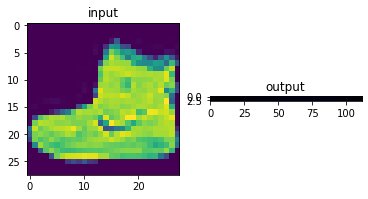

In [175]:
# sample = next(data)
fig, ax = plt.subplots(1,2)
image = Image.fromarray(train_images[0])
# resize to fit in conv
image = np.array(image.resize((28,28))).astype('float32')


print(image.shape)
input_crop = image.reshape(1, 1, *image.shape )

ax[0].imshow(image)
ax[0].set_title("input")
# feed through generator #
out = generator.predict(input_crop)
out[0].shape
ax[1].imshow(out[0])
ax[1].set_title("output")



Output does not resemble anything due to not being trained

Looking at how the discriminator is taking input/producing an output

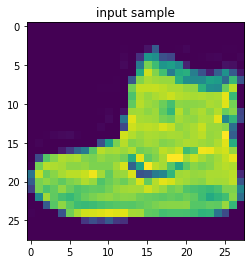

Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]
Discriminator output: [[[[0.49998778]
   [0.5000024 ]]]]


In [176]:
# sample = next(data)
fig, ax = plt.subplots(1,1)
image = Image.fromarray(train_images[0])
# resize to fit in conv
image = np.array(image.resize((28,28))).astype('float32')
ax.imshow(image)
ax.set_title("input sample")
plt.show()
to_avg = []

for step in range(15):
  image = Image.fromarray(train_images[1])
  # resize to fit in conv
  image = np.array(image.resize((28,28))).astype('float32')
  input_crop = image.reshape(1, 1, *image.shape )
  # feed through discrim #
  out = discriminator.predict(input_crop)
  print("Discriminator output: {}".format(out))
  to_avg.append(out)


As we can see: because we have not trained this net and there is no definition of fake vs. real image, the model is very very close to a 50/50 split in its predictions. AKA pure guess. 